In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d andrewmvd/covid19-cough-audio-classification


 99% 1.23G/1.24G [00:08<00:00, 206MB/s]
100% 1.24G/1.24G [00:08<00:00, 158MB/s]


In [ ]:
!unzip covid19-cough-audio-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: e8e7a8fc-a199-459b-8b47-96aae07cafdc.webm  
  inflating: e8eaf768-9997-4a63-ad2e-4a01c5adee86.json  
  inflating: e8eaf768-9997-4a63-ad2e-4a01c5adee86.webm  
  inflating: e8ebf8aa-107c-4f94-b24b-526e4f5f1b64.json  
  inflating: e8ebf8aa-107c-4f94-b24b-526e4f5f1b64.ogg  
  inflating: e8f0479e-9e75-41e7-806d-dfad3b86ac82.json  
  inflating: e8f0479e-9e75-41e7-806d-dfad3b86ac82.webm  
  inflating: e8f243e4-d456-4b40-bf1e-b6bab899453f.json  
  inflating: e8f243e4-d456-4b40-bf1e-b6bab899453f.webm  
  inflating: e8f45f08-6e1d-4c06-ae96-ce9fe43c91d1.json  
  inflating: e8f45f08-6e1d-4c06-ae96-ce9fe43c91d1.webm  
  inflating: e8f4b378-f21c-40a6-add1-2831323f544e.json  
  inflating: e8f4b378-f21c-40a6-add1-2831323f544e.webm  
  inflating: e8f5bcaa-487d-4e86-93a0-a89c9f87ae93.json  
  inflating: e8f5bcaa-487d-4e86-93a0-a89c9f87ae93.webm  
  inflating: e8f6c938-a196-4e42-9007-a173e99d3700.json  
  inflating: e8f6c938-a196-4e42-9007-a

##PART1: Data Exploration



*  Experts labels are not fully consistent and often in disagreement for the same audio recording. Cough type and congestion are the features where the four experts tend to agree more. Everything else should be used - if used at all - with care.
* A certain number of records does not contain any cough audio, they are spurious. We have run XGBoost classification to idenitfy records with coughs. Score of classifier is contained in column cough_detected. It is suggested  to cut at cough_detected > 0.8, that should leave us with a contamination of non-cough audio by about 4.6%. 

*   On top of that, the SNR variable tells you about the Signal-to-Noise Ratio ofthe cough audio. High SNR correspond to clearer cough sounds










In [ ]:
import numpy as np
import datetime as dt
import pandas as pd 
import librosa
from librosa import display
import os
import pickle
from timeit import default_timer as timer
from collections import OrderedDict 
from keras import metrics, optimizers 
from datetime import datetime

pd.set_option("display.max_columns", None)

In [ ]:
import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        if filename.endswith(".csv"):
            print(os.path.join(dirname, filename))

/content/metadata_compiled.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_test.csv
/content/sample_data/california_housing_train.csv


In [ ]:
import matplotlib.pyplot as plt 
import itertools
import plotly.graph_objects as ply_go
import plotly.figure_factory as ply_ff
import plotly.colors as ply_colors #.sequential.Oranges as orange_palette
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

Import metadata file and visualise key metadata properties

In [ ]:
metadata=pd.read_csv('metadata_compiled.csv') 
metadata


,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27545,fff30afc-db62-4408-a585-07ca9a254fcc,2020-11-05T08:26:04.219206+00:00,0.9698,11.109221,40.7,29.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27546,fff3ff61-2387-4139-938b-539db01e6be5,2020-06-28T21:28:21.530881+00:00,0.5257,43.932829,51.6,-0.2,NaN,female,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27547,fff474bf-39a4-4a61-8348-6b992fb5e439,2020-04-10T05:10:36.787070+00:00,0.1945,27.702036,-39.0,-68.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27548,fffaa9f8-4db0-46c5-90fb-93b7b014b55d,2020-04-13T18:58:26.954663+00:00,0.0243,8.825849,41.0,28.8,50.0,male,True,True,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# convert strings 'True'/'False' to genuine booleans
cols_to_boolean = (['respiratory_condition', 'fever_muscle_pain',
                     'dyspnea_1', 'wheezing_1', 'stridor_1','choking_1', 'congestion_1', 'nothing_1',
                     'dyspnea_2', 'wheezing_2', 'stridor_2','choking_2', 'congestion_2', 'nothing_2',
                     'dyspnea_3', 'wheezing_3', 'stridor_3','choking_3', 'congestion_3', 'nothing_3',
                     'dyspnea_4', 'wheezing_4', 'stridor_4','choking_4', 'congestion_4', 'nothing_4'])

In [ ]:
for c in cols_to_boolean:
    metadata.loc[metadata[c].notnull(),c] = metadata.loc[metadata[c].notnull(),c].astype(bool) 

print("NULL or NA records for each column:")
print( metadata.isnull().sum() )
    
cols_to_fillna = ['gender', 'status','diagnosis_1','diagnosis_2','diagnosis_3','diagnosis_4']
metadata[cols_to_fillna]=metadata[cols_to_fillna].fillna('n/a')

NULL or NA records for each column:
uuid                         0
datetime                     0
cough_detected               0
SNR                          0
latitude                 11466
longitude                11466
age                      12332
gender                   11326
respiratory_condition    11326
fever_muscle_pain        11326
status                   11326
quality_1                26730
cough_type_1             26748
dyspnea_1                26730
wheezing_1               26730
stridor_1                26730
choking_1                26730
congestion_1             26730
nothing_1                26730
diagnosis_1              26748
severity_1               26748
quality_2                26730
cough_type_2             26749
dyspnea_2                26730
wheezing_2               26730
stridor_2                26730
choking_2                26730
congestion_2             26730
nothing_2                26730
diagnosis_2              26748
severity_2               26748
qua

In [ ]:
metadata.head(5)

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,n/a,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN
4,0012c608-33d0-4ef7-bde3-75a0b1a0024e,2020-04-15T01:03:59.029326+00:00,0.0482,0.000000,-16.5,-71.5,NaN,n/a,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN


Visualise metadata

In [ ]:
my_title_layout = dict({"text":"my distribution", 'xanchor':'center', 'x':0.5, 'y':0.9, 'font':{'size':24}})
my_xaxis_layout = dict(title=dict(text="my x axis", font={'size':16}))
my_layout = dict(title=my_title_layout,
                xaxis= my_xaxis_layout)
bin_size_dict = dict(cough_detected=0.001,SNR=0.5, age=1, gender=1, respiratory_condition=1, fever_muscle_pain=1, status=1 )
xaxis_title_dict = dict(cough_detected="Cough Detection Score",SNR="Signal-to-Noise Ratio" , age="Age", 
                        gender="Gender", respiratory_condition="Resp. Condition", fever_muscle_pain="Fever", status="Status" )


In [ ]:
def summarise_pivot_df(df, xcols, ycols, valcol):
    summary_df = df[xcols+ycols+valcol]
    summary_df.loc[summary_df[xcols[0]].isnull(),xcols] = 'n/a' #replace NA with a default string
    summary_df.loc[summary_df[ycols[0]].isnull(),ycols] = 'n/a' #replace NA with a default string
    summary_df = summary_df.groupby(xcols+ycols).count().reset_index()
    print(summary_df)
    pivot_df = pd.pivot_table(data=summary_df,values=valcol, index=xcols,columns=ycols)
    pivot_df.columns = [ c[1] for c in pivot_df.columns ] # get rid of multiindex
    return pivot_df

def pandas_to_plotly_heatdata(df):
    #print(df.index)
    return {'x': df.columns.tolist(),
            'y': df.index.tolist(),
            'z': df.values.tolist()}

# Heatmap Fever vs status
meta_summary_df = summarise_pivot_df(metadata, ['fever_muscle_pain'], ['status'], ['uuid'])
meta_summary_df = meta_summary_df[['healthy','symptomatic','COVID-19','n/a']]
n = meta_summary_df.sum().sum()
print(meta_summary_df.head(5) )

heat_data = ply_go.Heatmap(pandas_to_plotly_heatdata(meta_summary_df), 
                           colorscale=ply_colors.sequential.Oranges,
                           colorbar={'title':"Entries", 'titleside':"top"} ,
                           text=meta_summary_df.values)
rounded_annotation = [ ["NA" if pd.isnull(c) else "{:.0f}".format(c) for c in r] for r in heat_data['z']]
fig = ply_ff.create_annotated_heatmap(z=heat_data['z'], 
                                      x=heat_data['x'],
                                      y=[i for i,t in enumerate(heat_data['y'])],
                                      annotation_text=rounded_annotation,
                                      colorscale=heat_data['colorscale'],
                                      showscale=True,
                                      colorbar=heat_data['colorbar']  )
fig.update_layout( yaxis={"title":{"text":"Muscle Pain"},
                          "tickmode":'array',"tickvals":[2,1,0],"ticktext":['n/a','Yes','No']})
fig.show()

heat_data = ply_go.Heatmap(pandas_to_plotly_heatdata(100.0*meta_summary_df/n) ,
                           colorscale=ply_colors.sequential.Oranges,
                          colorbar={'title':"Percentage", 'titleside':"top"})
rounded_annotation = [ [ "NA" if pd.isna(c)  else "{:.2f}%".format(c)  for c in r] for r in heat_data['z']]
fig = ply_ff.create_annotated_heatmap(z=heat_data['z'], 
                                      x=heat_data['x'],
                                      y=[i for i,t in enumerate(heat_data['y'])],
                                      annotation_text=rounded_annotation,
                                      colorscale=heat_data['colorscale'],
                                      showscale=True,
                                      colorbar=heat_data['colorbar'])
fig.update_layout( yaxis={"title":{"text":"Muscle Pain"},
                          "tickmode":'array',"tickvals":[2,1,0],"ticktext":['n/a','Yes','No']})
fig.show()

# Heatmap RespCond vs status
meta_summary_df = summarise_pivot_df(metadata, ['respiratory_condition'], ['status'], ['uuid'])
meta_summary_df = meta_summary_df[['healthy','symptomatic','COVID-19','n/a']]
n = meta_summary_df.sum().sum()
#print(meta_summary_df.head(5) )
#print( pandas_to_plotly_heatdata(meta_summary_df) )
heat_data = ply_go.Heatmap(pandas_to_plotly_heatdata(meta_summary_df), 
                           colorscale=ply_colors.sequential.Oranges,
                           colorbar={'title':"Entries", 'titleside':"top"} ,
                           text=meta_summary_df.values)
rounded_annotation = [ ["NA" if pd.isnull(c) else "{:.0f}".format(c) for c in r] for r in heat_data['z']]
fig = ply_ff.create_annotated_heatmap(z=heat_data['z'], 
                                      x=heat_data['x'],
                                      #y=heat_data['y'],#
                                      y=[int(i) for i,t in enumerate(heat_data['y']) ],
                                      annotation_text=rounded_annotation,
                                      colorscale=heat_data['colorscale'],
                                      showscale=True,
                                      colorbar=heat_data['colorbar']  )
fig.update_layout( yaxis={"title":{"text":"REspiratory Condition"},
                          "tickmode":'array',"tickvals":[2,1,0,],"ticktext":['n/a','Yes','No']})
fig.show()

  fever_muscle_pain       status   uuid
0             False     COVID-19    821
1             False      healthy  11545
2             False  symptomatic   1930
3              True     COVID-19    334
4              True      healthy    934
5              True  symptomatic    660
6               n/a          n/a  11326
                   healthy  symptomatic  COVID-19      n/a
fever_muscle_pain                                         
False              11545.0       1930.0     821.0      NaN
True                 934.0        660.0     334.0      NaN
n/a                    NaN          NaN       NaN  11326.0


  respiratory_condition       status   uuid
0                 False     COVID-19    761
1                 False      healthy  10842
2                 False  symptomatic   1800
3                  True     COVID-19    394
4                  True      healthy   1637
5                  True  symptomatic    790
6                   n/a          n/a  11326


In [ ]:
# Heatmap Age vs status
metadata['age_class'] = 0 # NAs will end up here
metadata.loc[ (metadata['age']<40),'age_class'] = 1
metadata.loc[ (metadata['age']>=40) &(metadata['age']<60),'age_class'] = 2
metadata.loc[ (metadata['age']>=60),'age_class'] = 3

meta_summary_df = summarise_pivot_df(metadata, ['age_class'], ['status'], ['uuid'])
meta_summary_df = meta_summary_df[['healthy','symptomatic','COVID-19','n/a']]
n = meta_summary_df.sum().sum()
print(meta_summary_df.head(5) )
#print( pandas_to_plotly_heatdata(meta_summary_df) )
heat_data = ply_go.Heatmap(pandas_to_plotly_heatdata(meta_summary_df), 
                           colorscale=ply_colors.sequential.Oranges,
                           colorbar={'title':"Entries", 'titleside':"top"} ,
                           text=meta_summary_df.values)
rounded_annotation = [ ["NA" if pd.isnull(c) else "{:.0f}".format(c) for c in r] for r in heat_data['z']]
fig = ply_ff.create_annotated_heatmap(z=heat_data['z'], 
                                      x=heat_data['x'],
                                      y=heat_data['y'],#
                                      #y=[int(i) for i,t in enumerate(heat_data['y']) ],
                                      annotation_text=rounded_annotation,
                                      colorscale=heat_data['colorscale'],
                                      showscale=True,
                                      colorbar=heat_data['colorbar']  )
fig.update_layout( yaxis={"title":{"text":"Age"},
                          "tickmode":'array',"tickvals":[3,2,1,0,],"ticktext":['> 60 yo','40 - 60 yo','< 40 yo', 'n/a']})
fig.show()

    age_class       status   uuid
0           0     COVID-19    190
1           0      healthy    747
2           0          n/a  11326
3           0  symptomatic     69
4           1     COVID-19    638
5           1      healthy   6947
6           1  symptomatic   1652
7           2     COVID-19    268
8           2      healthy   3754
9           2  symptomatic    762
10          3     COVID-19     59
11          3      healthy   1031
12          3  symptomatic    107
           healthy  symptomatic  COVID-19      n/a
age_class                                         
0            747.0         69.0     190.0  11326.0
1           6947.0       1652.0     638.0      NaN
2           3754.0        762.0     268.0      NaN
3           1031.0        107.0      59.0      NaN


In [ ]:
import os
import json
import pandas
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import sklearn

In [ ]:
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
#from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input 
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from datetime import datetime
from sklearn import metrics

In [ ]:
print(metadata['status'].isnull().value_counts())
print(metadata['age'].isnull().value_counts())
print(metadata['respiratory_condition'].isnull().value_counts())
print(metadata['fever_muscle_pain'].isnull().value_counts())
print(metadata['gender'].isnull().value_counts())

False    27550
Name: status, dtype: int64
False    15218
True     12332
Name: age, dtype: int64
False    16224
True     11326
Name: respiratory_condition, dtype: int64
False    16224
True     11326
Name: fever_muscle_pain, dtype: int64
False    27550
Name: gender, dtype: int64


In [ ]:
print("metadata entries before cleaning NAs: {}".format(metadata.shape[0]))
metadata = metadata.loc[~((metadata['status'].isnull() ) | (metadata['age'].isnull()) | (metadata['respiratory_condition'].isnull()) | (metadata['fever_muscle_pain'].isnull()) |(metadata['gender'].isnull())  )]
print("metadata entries after cleaning NAs: {}".format(metadata.shape[0]))

metadata entries before cleaning NAs: 27550
metadata entries after cleaning NAs: 15218


In [ ]:
metadata['status'].value_counts()

healthy        11732
symptomatic     2521
COVID-19         965
Name: status, dtype: int64

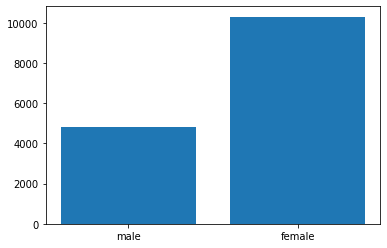

In [ ]:
import matplotlib.pyplot as plt
gen=["male","female"]
count=[metadata['gender'].value_counts()[1],metadata['gender'].value_counts()[0]]
plt.bar(gen,count)
plt.show()

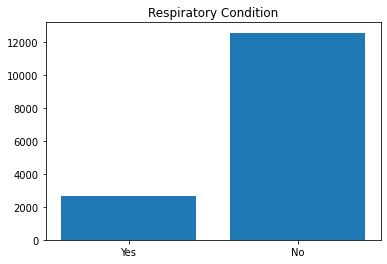

In [ ]:
gen=["Yes","No"]
count=[metadata['respiratory_condition'].value_counts()[1],metadata['respiratory_condition'].value_counts()[0]]
plt.title("Respiratory Condition")
plt.bar(gen,count)
plt.show()

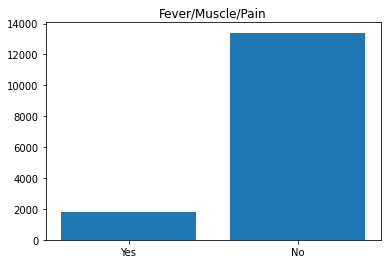

In [ ]:
gen=["Yes","No"]
count=[metadata['fever_muscle_pain'].value_counts()[1],metadata['fever_muscle_pain'].value_counts()[0]]
plt.title("Fever/Muscle/Pain")
plt.bar(gen,count)
plt.show()

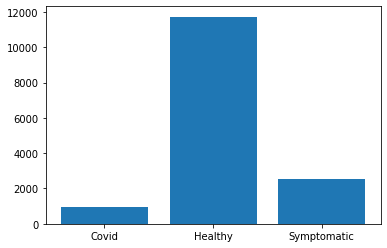

In [ ]:
gen=["Covid","Healthy","Symptomatic"]
count=[metadata['status'].value_counts()['COVID-19'],metadata['status'].value_counts()['healthy'],metadata['status'].value_counts()['symptomatic']]
plt.bar(gen,count)
plt.show()

gender
female    AxesSubplot(0.125,0.125;0.775x0.755)
male      AxesSubplot(0.125,0.125;0.775x0.755)
other     AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

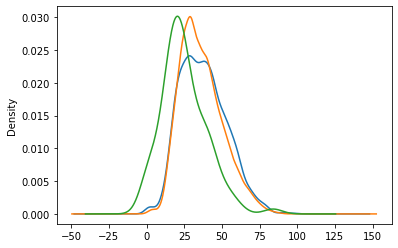

In [ ]:
metadata.groupby('gender').age.plot(kind='kde')

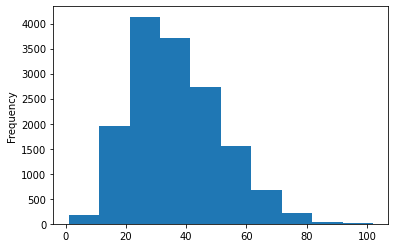

In [ ]:
metadata.age.plot(kind='hist')

In [ ]:
symp_df=metadata[metadata.status=='symptomatic']
symp_df=symp_df.head(1200)
symp_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4,age_class
12,0029d048-898a-4c70-89c7-0815cdcf7391,2020-07-16T03:01:55.059762+00:00,1.0000,9.624196,NaN,NaN,35.0,male,True,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,good,dry,False,False,False,False,False,True,upper_infection,mild,1
25,00432f00-2477-4faf-a440-cc1276065b4a,2020-04-30T11:01:13.536686+00:00,0.6911,15.926406,48.9,2.6,31.0,female,True,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
41,006d8d1c-2bf6-46a6-8ef2-1823898a4733,2020-04-22T10:24:21.408615+00:00,1.0000,13.284361,NaN,NaN,28.0,male,True,True,symptomatic,ok,dry,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
42,006daa68-31b7-44ab-b0c6-7e5ef4e1ebf7,2020-10-14T08:47:01.990751+00:00,0.9961,32.564843,NaN,NaN,33.0,female,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
58,008c1c9e-aeef-40c5-846c-24f1b964f884,2020-04-12T21:25:00.131353+00:00,1.0000,55.824914,48.9,2.7,44.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,good,wet,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13193,7a568e63-08a1-4be9-a33a-ad8348c22617,2020-09-24T18:56:23.624645+00:00,0.8961,18.534933,NaN,NaN,39.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
13203,7a6db0d1-ba36-4823-add6-47f7304d83d5,2020-08-21T12:44:11.606094+00:00,0.9669,10.108650,NaN,NaN,26.0,male,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
13228,7a97059d-41ad-4411-82a9-f38c91197320,2020-05-30T23:36:46.184121+00:00,0.7027,11.703798,NaN,NaN,21.0,female,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
13232,7aa19749-6bb8-40e1-a4ee-823290466b0f,2020-04-13T09:25:42.310644+00:00,0.9963,18.459386,39.6,-0.3,73.0,female,False,False,symptomatic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,3


In [ ]:
covid_df=metadata[metadata.status=='COVID-19']
covid_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4,age_class
133,01424527-9c3b-4b6e-96f1-9eea3150819b,2020-10-18T15:51:28.858079+00:00,0.0000,16.047069,48.9,2.5,39.0,female,False,False,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,no_cough,NaN,False,False,False,False,False,False,n/a,NaN,1
140,015576c8-2b03-4dcb-b251-78a984fe86fe,2020-06-22T00:21:42.091345+00:00,1.0000,12.265701,NaN,NaN,27.0,male,False,False,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,good,unknown,False,False,False,False,False,True,obstructive_disease,mild,1
144,015ec831-e765-44ee-aefc-10dfd95dec78,2020-04-14T03:28:58.264739+00:00,0.0000,16.549264,41.6,2.0,34.0,male,True,True,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,no_cough,NaN,False,False,False,False,False,False,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
149,01672ac0-dfd5-4aaf-b57b-d6dfa411b43d,2020-04-14T10:06:12.730478+00:00,0.0931,0.000000,NaN,NaN,1.0,other,True,True,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
155,0177b817-0ba3-498a-bc05-48bc66cc91b8,2020-04-14T10:55:38.245408+00:00,1.0000,20.441756,NaN,NaN,18.0,male,False,False,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,ok,dry,False,False,True,False,False,False,obstructive_disease,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27300,fd8d6e46-75de-42b3-a7ef-30d5294b915d,2020-05-05T17:57:01.830977+00:00,1.0000,13.224609,NaN,NaN,19.0,female,False,False,COVID-19,poor,unknown,False,False,False,False,False,True,lower_infection,mild,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
27315,fdbabb79-c296-4b93-9e02-06b290916fe7,2020-04-10T14:52:39.570226+00:00,1.0000,11.986657,-12.1,-77.0,42.0,male,False,False,COVID-19,ok,unknown,False,False,False,False,False,True,healthy_cough,pseudocough,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
27417,feb52c0e-de52-4706-aded-d9dcefcea62d,2020-04-10T21:18:32.936362+00:00,0.3081,0.000000,NaN,NaN,51.0,male,False,False,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
27519,ffa8bc1f-7ef8-48ef-a951-78a4f2897c0c,2020-11-10T13:38:45.060541+00:00,0.0118,0.000000,47.4,8.5,37.0,male,True,True,COVID-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1


In [ ]:
healthy_df=metadata[metadata.status=='healthy']
healthy_df=healthy_df.head(1200)
healthy_df

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4,age_class
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,2020-10-18T15:11:02.106636+00:00,0.7811,12.566406,45.7,4.9,20.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,1944e249-b0c8-4e10-ad8c-195d2ad4833c,2020-04-16T11:33:43.261566+00:00,0.7941,0.000000,NaN,NaN,26.0,male,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
2712,194584e5-fa76-4a88-a7ab-073095aab3cc,2020-11-13T10:33:41.172373+00:00,0.9964,22.819712,46.9,8.4,42.0,male,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
2714,1948ec03-fa5c-4301-a88b-29400c67903f,2020-04-21T15:10:00.617360+00:00,0.2925,15.748968,NaN,NaN,32.0,female,False,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
2716,194bcca1-e83c-4d5a-b49f-9841f967712f,2020-04-17T03:04:43.137202+00:00,0.9941,14.398196,31.8,-93.2,31.0,female,True,False,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1


In [ ]:
import librosa
import librosa.display 
import json 
import IPython.display as ipd

Read the input data, group them based on datatype

In [ ]:
directory='/content/'
def retrive_data():
    json_files = []
    audio_files = []
    
    file_list = os.listdir(directory)
    json_file = [file for file in file_list if ".json" in str(file)]
    audio_file = [file for file in file_list if ".webm" in str(file)]
    audio_file2 = [file for file in file_list if ".ogg" in str(file)]
    return json_file, audio_file, audio_file2
    
json_files, audio_files, audio_files2 = retrive_data()


Print total input data count

In [ ]:
print("total files in directory: ", len([name for name in os.listdir(directory)]))
print("json file count: ", len(json_files))
print("webm file count: ", len(audio_files))
print("ogg file count: ", len(audio_files2))

total files in directory:  55108
json file count:  27551
webm file count:  25985
ogg file count:  1565


Process json data and create Pandas dataframe for better analysis and understanding

In [ ]:
def load_json_info():
    json_data = []
    columns = []
    audio_file_name = []
    
    for filename in json_files:
        json_path = os.path.join(directory, filename)
        
        with open(json_path, mode='r') as recurse:
            json_contents = json.load(recurse)

            for key in json_contents.keys():
                columns.append(key)
    
    columns = set(columns)
    for filename in json_files:
        name = filename.replace(".json", "")
        is_present = 1 if name + ".webm" in audio_files else 0
        json_path = os.path.join(directory, filename)
        
        with open(json_path, mode='r') as recurse:
            json_contents = json.load(recurse)
            
            row_data = []
            for key in columns:
                row_data.append(json_contents.get(key))
            
            audio_file_name.append(is_present)
            json_data.append(row_data)
    
    dataframe = pd.DataFrame(json_data, columns=columns) 
    dataframe['audio_clip_present'] = audio_file_name
    return dataframe, columns
        
dataframe, columns = load_json_info()

List down the missing fields in the input dataframe

In [ ]:
dataframe.loc[0:5, :] 


,key,cough_detected,age,expert_labels_4,longitude,respiratory_condition,expert_labels_1,latitude,datetime,gender,expert_labels_2,fever_muscle_pain,status,expert_labels_3,username,audio_clip_present
0,None,0.9828,27,"{'quality': 'good', 'cough_type': 'dry', 'dysp...",21.4,False,None,42.0,2020-04-13T12:03:04.660716+00:00,male,None,False,healthy,None,None,1
1,None,0.7174,34,None,None,False,None,None,2020-04-11T11:40:23.309600+00:00,male,None,True,healthy,None,None,1
2,None,0.0422,None,None,None,None,None,None,2020-10-17T09:31:54.149044+00:00,None,None,None,None,None,None,0
3,None,0.9816,38,None,23.9,True,None,54.9,2020-04-14T07:19:42.863072+00:00,male,None,False,healthy,None,None,1
4,None,0.1393,None,None,3.4,None,None,43.5,2020-10-18T16:01:16.757312+00:00,None,None,None,None,None,None,1
5,None,0.3183,63,None,4.4,True,None,50.9,2020-11-02T01:17:18.148807+00:00,male,None,True,symptomatic,None,None,1


In [ ]:
dataframe.isnull().sum()

key                      27550
cough_detected               1
age                      12333
expert_labels_4          26731
longitude                11467
respiratory_condition    11327
expert_labels_1          26731
latitude                 11467
datetime                     1
gender                   11327
expert_labels_2          26731
fever_muscle_pain        11327
status                   11327
expert_labels_3          26731
username                 27550
audio_clip_present           0
dtype: int64

In [ ]:
dataframe.age.fillna(0, inplace=True)

dataframe['age'] = dataframe['age'].astype(float)
dataframe['date_time'] = pd.to_datetime(dataframe.datetime)

Listen to Sample audio and its graph visualization

In [ ]:
audio , sr = librosa.load(directory+audio_files[0])
ipd.Audio(audio_files[0])

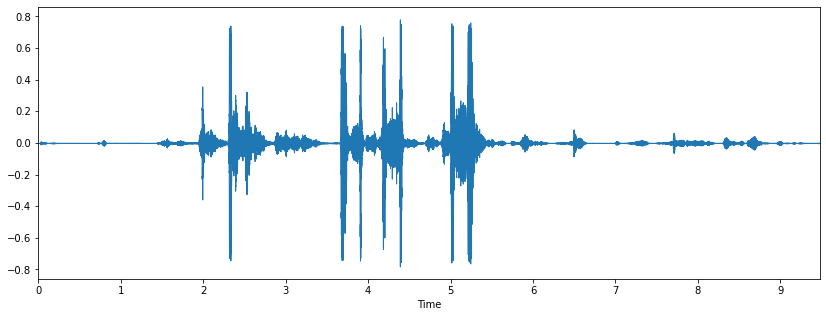

In [ ]:
%matplotlib inline
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, sr=sr)

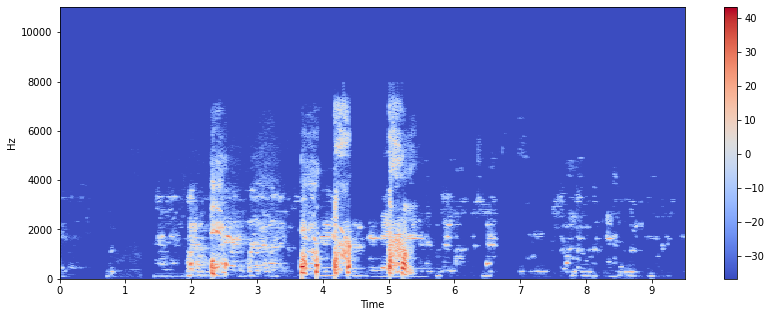

In [ ]:
X = librosa.stft(audio)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

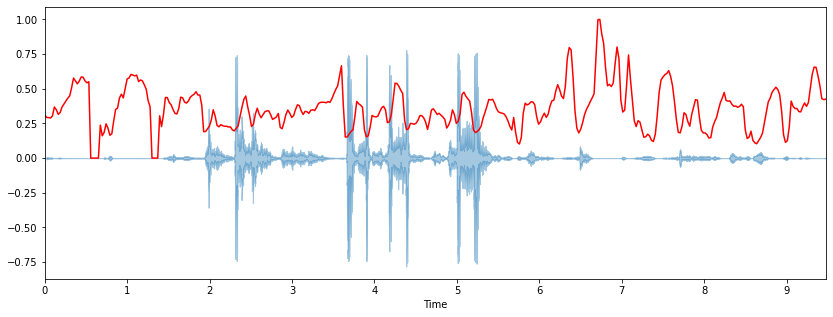

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(audio, sr=sr)[0]

# Computing the time variable for visualization
plt.figure(figsize=(14, 5))
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
librosa.display.waveplot(audio, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

In [ ]:
def feature_extract(file):
    audio,sr=librosa.load(file,res_type='kaiser_fast')
    mfccs_feature=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=40)
    mfccs_scaled_feature=np.mean(mfccs_feature.T,axis=0)
    return mfccs_scaled_feature

In [ ]:
import warnings
warnings.filterwarnings('ignore', '.*PySoundFile failed. Trying audioread instead*.', )
extracted_feature=[]
for idx,row in metadata.iterrows():
    file_name='/content/'+row["uuid"]+".webm"
    tmp_audiofilename = row["uuid"]+".webm"
    if not os.path.exists(file_name):
        # try to look for a .ogg file
        tmp_audiofilename = row["uuid"]+".ogg"
        file_name='/content/'+row["uuid"]+".ogg"
        if not os.path.exists(file_name):
                warnings.warn("WARNING! Could not find audio file for UUID: {}  . Skipping.".format(row["uuid"]))
                continue
        if idx%2==0:
            print(idx,"+ files Read.....")
    data=feature_extract(file_name)
    extracted_feature.append([row["uuid"],data])

70 + files Read.....
248 + files Read.....
260 + files Read.....
358 + files Read.....
430 + files Read.....
502 + files Read.....
550 + files Read.....
564 + files Read.....
574 + files Read.....
646 + files Read.....
678 + files Read.....
690 + files Read.....
718 + files Read.....
732 + files Read.....
752 + files Read.....
942 + files Read.....
1042 + files Read.....
1162 + files Read.....
1170 + files Read.....
1276 + files Read.....
1390 + files Read.....
1448 + files Read.....
1572 + files Read.....
1642 + files Read.....
1670 + files Read.....
1674 + files Read.....
1796 + files Read.....
1936 + files Read.....
1956 + files Read.....
2038 + files Read.....
2080 + files Read.....
2138 + files Read.....
2190 + files Read.....
2244 + files Read.....
2384 + files Read.....
2474 + files Read.....
2590 + files Read.....
2598 + files Read.....
2638 + files Read.....
2646 + files Read.....
2666 + files Read.....
2684 + files Read.....
2700 + files Read.....
2726 + files Read.....
2788 

In [ ]:
extracted_feature_df=pd.DataFrame(extracted_feature,columns=["uuid","mfcc"])
extracted_feature_df

,uuid,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,"[-563.2874, 18.237911, -2.340043, 5.7208796, -..."
1,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,"[-736.3254, 55.839046, 9.053165, 1.8925929, -1..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,"[-279.63657, 102.03405, -26.998037, 16.887787,..."
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,"[-519.8216, 26.09443, -28.72866, 8.0029955, -1..."
4,001e2f19-d81c-4029-b33c-d2db56b23a4a,"[-524.22455, 17.532991, -1.9887313, 6.611334, ..."
...,...,...
15213,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,"[-277.23294, 96.564735, -2.5922356, -13.449952..."
15214,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,"[-420.7814, 24.159294, -7.4626083, -1.1088482,..."
15215,ffeea120-92a4-40f9-b692-c3865c7a983f,"[-509.06058, 29.669346, -13.902607, 3.8848345,..."
15216,fff13fa2-a725-49ef-812a-39c6cedda33d,"[-542.4574, 25.5874, -14.501992, 1.2716641, -2..."


In [ ]:
extracted_feature_df.to_csv('mfcc.csv',index=False)

In [ ]:
metadata['fever_muscle_pain']=metadata['fever_muscle_pain'].apply(lambda x: 0 if x==False else 1)
metadata['gender']=metadata['gender'].apply(lambda x: 0 if x=="female" else 1)
metadata['respiratory_condition']=metadata['respiratory_condition'].apply(lambda x: 0 if x==False else 1)
metadata

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,status,quality_1,cough_type_1,dyspnea_1,wheezing_1,stridor_1,choking_1,congestion_1,nothing_1,diagnosis_1,severity_1,quality_2,cough_type_2,dyspnea_2,wheezing_2,stridor_2,choking_2,congestion_2,nothing_2,diagnosis_2,severity_2,quality_3,cough_type_3,dyspnea_3,wheezing_3,stridor_3,choking_3,congestion_3,nothing_3,diagnosis_3,severity_3,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4,age_class
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,2
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,2020-04-12T04:02:18.159383+00:00,0.9301,20.146058,40.0,-75.1,34.0,1,1,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,2020-04-13T22:23:06.997578+00:00,0.9968,13.146502,NaN,NaN,21.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,2020-10-18T15:11:02.106636+00:00,0.7811,12.566406,45.7,4.9,20.0,1,1,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,2020-04-22T05:40:51.730942+00:00,0.5591,11.209351,13.0,77.6,26.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,2020-06-05T03:41:37.481463+00:00,1.0000,33.661082,-34.5,-58.5,23.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,good,dry,False,False,False,False,False,True,healthy_cough,pseudocough,1
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,2020-05-02T10:18:27.348859+00:00,0.9784,9.635425,14.3,121.1,22.0,1,0,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,2020-04-13T17:51:36.956822+00:00,0.7154,14.162062,31.9,34.7,21.0,1,1,0,healthy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,n/a,NaN,1


In [ ]:
metadata2=metadata[['uuid','age','respiratory_condition','fever_muscle_pain','gender','status']]
metadata2

,uuid,age,respiratory_condition,fever_muscle_pain,gender,status
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,0,0,1,healthy
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,46.0,0,0,1,healthy
3,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,1,0,1,healthy
5,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,0,0,1,healthy
8,001e2f19-d81c-4029-b33c-d2db56b23a4a,20.0,1,0,1,healthy
...,...,...,...,...,...,...
27541,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,26.0,0,0,1,healthy
27542,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,0,0,1,healthy
27543,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,0,0,1,healthy
27544,fff13fa2-a725-49ef-812a-39c6cedda33d,21.0,1,0,1,healthy


In [ ]:
all_data = metadata2.merge(extracted_feature_df,how='inner',on="uuid")
all_data

,uuid,age,respiratory_condition,fever_muscle_pain,gender,status,mfcc
0,00039425-7f3a-42aa-ac13-834aaa2b6b92,15.0,0,0,1,healthy,"[-563.2874, 18.237911, -2.340043, 5.7208796, -..."
1,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,46.0,0,0,1,healthy,"[-736.3254, 55.839046, 9.053165, 1.8925929, -1..."
2,0009eb28-d8be-4dc1-92bb-907e53bc5c7a,34.0,1,0,1,healthy,"[-279.63657, 102.03405, -26.998037, 16.887787,..."
3,001328dc-ea5d-4847-9ccf-c5aa2a3f2d0f,21.0,0,0,1,healthy,"[-519.8216, 26.09443, -28.72866, 8.0029955, -1..."
4,001e2f19-d81c-4029-b33c-d2db56b23a4a,20.0,1,0,1,healthy,"[-524.22455, 17.532991, -1.9887313, 6.611334, ..."
...,...,...,...,...,...,...,...
15213,ffe5e2a4-ef67-464d-b1cd-b0e321f6a2dd,26.0,0,0,1,healthy,"[-277.23294, 96.564735, -2.5922356, -13.449952..."
15214,ffedc843-bfc2-4ad6-a749-2bc86bdac84a,23.0,0,0,1,healthy,"[-420.7814, 24.159294, -7.4626083, -1.1088482,..."
15215,ffeea120-92a4-40f9-b692-c3865c7a983f,22.0,0,0,1,healthy,"[-509.06058, 29.669346, -13.902607, 3.8848345,..."
15216,fff13fa2-a725-49ef-812a-39c6cedda33d,21.0,1,0,1,healthy,"[-542.4574, 25.5874, -14.501992, 1.2716641, -2..."


In [ ]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

In [ ]:
x=np.array(all_data[['age','gender','respiratory_condition','fever_muscle_pain']])
a=np.array(all_data['mfcc'].tolist())
y=np.array(all_data['status'].tolist())
x_concat=np.concatenate((a, x), axis=1)

In [ ]:
x_concat

array([[-563.28741455,   18.23791122,   -2.34004307, ...,    1.        ,
           0.        ,    0.        ],
       [-736.32537842,   55.83904648,    9.05316544, ...,    1.        ,
           0.        ,    0.        ],
       [-279.63656616,  102.03404999,  -26.99803734, ...,    1.        ,
           1.        ,    0.        ],
       ...,
       [-509.06057739,   29.66934586,  -13.90260696, ...,    1.        ,
           0.        ,    0.        ],
       [-542.45739746,   25.58740044,  -14.50199223, ...,    1.        ,
           1.        ,    0.        ],
       [-265.28509521,  131.16690063,  -43.66090775, ...,    1.        ,
           1.        ,    1.        ]])

In [ ]:
y=to_categorical(labelencoder.fit_transform(y))

In [ ]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
y.shape

(15218, 3)

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(x_concat,y,test_size=0.2,random_state=0)

In [ ]:
X_train

array([[-407.63574219,   70.28656006,    0.52316356, ...,    1.        ,
           0.        ,    0.        ],
       [-398.36425781,   55.33919144,  -27.07718658, ...,    1.        ,
           0.        ,    0.        ],
       [-302.0284729 ,   50.8548584 ,    9.39146328, ...,    1.        ,
           1.        ,    0.        ],
       ...,
       [-516.46075439,   37.8420639 ,    7.78157949, ...,    1.        ,
           0.        ,    0.        ],
       [-442.81124878,   33.92420197,   -9.91741943, ...,    1.        ,
           0.        ,    0.        ],
       [-510.59375   ,   38.86768341,   -7.1948247 , ...,    1.        ,
           0.        ,    0.        ]])

In [ ]:
X_train=np.array(X_train)
num_labels=y.shape[1]

In [ ]:
X_train.shape

(12174, 44)

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(x_concat.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 100)               4500      
                                                                 
 activation_36 (Activation)  (None, 100)               0         
                                                                 
 dropout_27 (Dropout)        (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 200)               20200     
                                                                 
 activation_37 (Activation)  (None, 200)               0         
                                                                 
 dropout_28 (Dropout)        (None, 200)               0         
                                                                 
 dense_40 (Dense)            (None, 100)              

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
366/381 [===========================>..] - ETA: 0s - loss: 6.5048 - accuracy: 0.6286
Epoch 1: val_loss improved from inf to 0.81153, saving model to saved_models/audio_classification.hdf5
381/381 [==============================] - 2s 4ms/step - loss: 6.3030 - accuracy: 0.6309 - val_loss: 0.8115 - val_accuracy: 0.7809
Epoch 2/100
377/381 [============================>.] - ETA: 0s - loss: 0.9151 - accuracy: 0.7343
Epoch 2: val_loss improved from 0.81153 to 0.71286, saving model to saved_models/audio_classification.hdf5
381/381 [==============================] - 1s 3ms/step - loss: 0.9127 - accuracy: 0.7348 - val_loss: 0.7129 - val_accuracy: 0.7809
Epoch 3/100
367/381 [===========================>..] - ETA: 0s - loss: 0.7654 - accuracy: 0.7610
Epoch 3: val_loss improved from 0.71286 to 0.68189, saving model to saved_models/audio_classification.hdf5
381/381 [==============================] - 1s 3ms/step - loss: 0.7639 - accuracy: 0.7615 - val_loss: 0.6819 - val_accuracy: 0.7809

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7808803915977478


In [ ]:
input=X_test[2]
input_array=np.asarray(input)
input_reshaped=input_array.reshape(1,-1)
input_reshaped.shape
model.predict(input_reshaped)

1/1 [==============================] - 0s 111ms/step


array([[0.06420393, 0.76825404, 0.16754209]], dtype=float32)

In [ ]:
def ANN_predict(file_name,predict_demo_fac):
    predict_data=feature_extract(file_name)
    #'age','gender','respiratory_condition','fever_muscle_pain' order
    predict_concat=np.concatenate((predict_data, predict_demo_fac), axis=0)
    input=predict_concat
    input_array=np.asarray(input)
    input_reshaped=input_array.reshape(1,-1)
    input_reshaped.shape
    print("  Covid-19   Healthy   Symptomatic")
    print(model.predict(input_reshaped))




filename='/content/00039425-7f3a-42aa-ac13-834aaa2b6b92.webm'
predict_demo_fac=[19,1,0,0]
ANN_predict(filename,predict_demo_fac)

  Covid-19   Healthy   Symptomatic
1/1 [==============================] - 0s 51ms/step
[[0.06420393 0.76825404 0.16754209]]
